# HW 1, Warmup

In [1]:
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt

Сачала сэмплируем данные и построим обучающую и валидационную выборки

In [2]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

xs_all = sample_data()

n = xs_all.shape[0]
n_train = int(n * 0.8)
xs_train, xs_val = xs_all[:n_train], xs_all[n_train:]

Для удобства сделаем загрузчик данных

In [3]:
batch_size = 100

def collate_fn(xs):
    xs = torch.LongTensor(xs)
    xs_one_hot = F.one_hot(xs, 100).float()
    return xs_one_hot

train_data_loader = data.DataLoader(
    dataset=xs_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_data_loader = data.DataLoader(
    dataset=xs_val,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

Теперь построим саму модель априорной плотности вероятности
$$p_{\theta}(x) = \frac{e^{\theta_x}}{\sum_{x'} e^{\theta_{x'}}}$$

In [4]:
class ApriorProb(nn.Module):
    def __init__(self, size):
        super(ApriorProb, self).__init__()
        
        self.theta = nn.Parameter(torch.zeros(size))
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        p = self.theta
        p = self.softmax(p)
        p = torch.stack([p] * x.size(0), 0)
        x = (x * p).sum(dim=1)
        return x

В качестве ошибки возьмем логарифмическую функцию правдоподобия

In [5]:
class MLLELoss(nn.Module):
    eps = 1e-9
    
    def __init__(self):
        super(MLLELoss, self).__init__()

    def forward(self, ps):
        loss = -torch.log(ps + MLLELoss.eps)
        loss = loss.mean()
        return loss

Обучим модель

100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


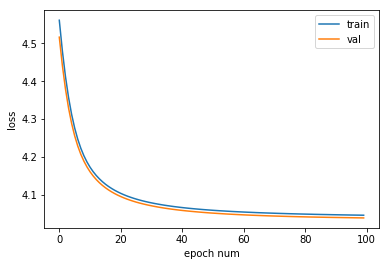

In [6]:
epochs = 100
lr = 0.1

model = ApriorProb(100)

criterion = MLLELoss()

optimizer = optim.SGD(model.parameters(), lr)

losses_train = []
losses_val = []
for i in tqdm(range(epochs)):
    losses = []
    model.train()
    for xs in train_data_loader:
        optimizer.zero_grad()

        ps = model(xs)
        loss = criterion(ps)

        losses.append(loss.item())

        loss.backward()
        optimizer.step()
            
    losses_train.append(np.array(losses).mean())
    
    losses = []
    model.eval()
    with torch.no_grad():
        for xs in val_data_loader:
            ps = model(xs)
            loss = criterion(ps)
            
            losses.append(loss.item())
            
    losses_val.append(np.array(losses).mean())
        
plt.plot(range(epochs), losses_train, label="train")
plt.plot(range(epochs), losses_val, label="val")
plt.xlabel('epoch num')
plt.ylabel('loss')
plt.legend()
plt.show()

Модель почти сошлась и даже не переобучилась

Теперь посмотрим на реальное распределение $X$ и на то, что выучила модель.

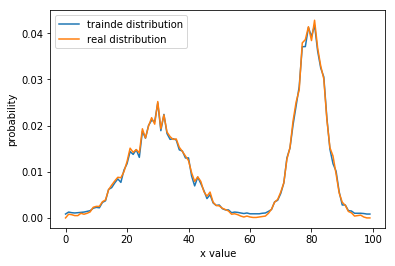

In [7]:
model.eval()
with torch.no_grad():
    xs = list(range(100))
    xs = collate_fn(xs)
    trained_ps = list(model(xs).numpy())

counter = Counter(xs_all)
real_ps = [counter[x] / len(xs_all) for x in range(100)]
    
plt.plot(range(100), trained_ps, label="trainde distribution")
plt.plot(range(100), real_ps, label="real distribution")
plt.xlabel('x value')
plt.ylabel('probability')
plt.legend()
plt.show()

Вышло неплохо